# Catchment delineation

In this notebook we will

1. ... determine the catchment area from a given pouring point based on a digital elevation model (DEM) 
2. ... determine all glaciers within that catchment area and download the glacier characteristics
3. ... create a glacier profile based on the ice thickness and DEM of each glacier

We will use Google Earth Engine (GEE) to retrieve the DEM and to perform spatial calculations. Use can use different DEMs as long as they are available in the *Google Earth Engine Data Catalog* (https://developers.google.com/earth-engine/datasets/catalog). The information of the used DEM must be specified in the `config.ini` file.

Let's start by importing required packages and defining functions/constants.

In [1]:
# Google Earth Engine packages
import ee
import geemap

# other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Define a function to plot the digital elevation model
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()
    

# constants
ee_img = 'Image'
ee_ico = 'ImageCollection'

First of all, the Google Earth Engine (GEE) access must be initialized. When using it for the first time on this machine, you need to authenticate first. When using <code>mybinder.org</code> you need to authenticate everytime a new session has been launched. **Copy the generated token and paste it into the input field to proceed**.

Official Google Help Guide for <code>ee.Authenticate()</code>:

> Prompts you to authorize access to Earth Engine via OAuth2.
>
> Directs you to a authentication page on the Code Editor server at code.earthengine.google.com/client-auth. You will need to pick a Cloud Project to hold your developer configuration (OAuth Client). This can be the same Cloud Project that you already use in the Code Editor, if you have not set up an OAuth client on the project already.
>
> The setup page also lets you choose to make the notebook access read-only. This is recommended if you are running a notebook with code that you didn't write and which may be malicious. Any operations which try to write data will fail.
>
> The credentials obtained by ee.Authenticate() will be written to a persistent token stored on the local machine. ee.Initialize() will automatically use the persistent credentials, if they exist. To use service account credentials
>
> Source: https://developers.google.com/earth-engine/apidocs/ee-authenticate

In [2]:
# initialize GEE at the beginning of session
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()         # authenticate when using GEE for the first time
    ee.Initialize()

New read from the `config.ini` file which is used throughout the different notebooks:

- input/output folders for data imports and downloads
- filenames (DEM, GeoPackage)
- coordinates of the defined discharge point (Lat/Long)
- used DEM from GEE data catalog
- show/hide GEE map in notebooks

In [6]:
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get file config from config.ini
output_folder = config['FILE_SETTINGS']['DIR_OUTPUT']
filename = output_folder + config['FILE_SETTINGS']['DEM_FILENAME']
output_gpkg = output_folder + config['FILE_SETTINGS']['GPKG_NAME']

# get used GEE DEM, coords and other settings
dem_config = ast.literal_eval(config['CONFIG']['DEM'])
y, x = ast.literal_eval(config['CONFIG']['COORDS'])
show_map = config.getboolean('CONFIG','SHOW_MAP')

# print config data
print(f'Used DEM: {dem_config[3]}')
print(f'Coordinates of discharge point: Lat {y}, Long {x}')

Used DEM: MERIT Hydro Elevation
Coordinates of discharge point: Lat 41.994671, Long 70.636229


## Start GEE and download DEM

Now we are ready to go. Let's start with the base map if enabled in `config.ini`. The individual steps can be traced using the map since more and more layers will be added through the course of the notebook. <a id="map"></a>

In [4]:
if show_map:
    Map = geemap.Map()
    display(Map)
else:
    print("Map view disabled in config.ini")

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Load the defined DEM from GEE catalog and add is as a new layer to map.

In [7]:
if dem_config[0] == ee_img:
    image = ee.Image(dem_config[1]).select(dem_config[2])
elif dem_config[0] == ee_ico:
    image = ee.ImageCollection(dem_config[1]).select(dem_config[2]).mosaic()

if show_map:
    srtm_vis = { 'bands': dem_config[2],
                 'min': 0,
                 'max': 6000,
                'palette': ['000000', '478FCD', '86C58E', 'AFC35E', '8F7131','B78D4F', 'E2B8A6', 'FFFFFF']
               }

    Map.addLayer(image, srtm_vis, dem_config[3], True, 0.7)

Add configured discharge point to map and automatically draw box with **40km** in all directions. 

**<font color="red">Attention!</font>** Please check whether automatically added box seems reasonable. Alternatively, a manual box can be drawn which will be considered in the next step for the catchment deliniation. **The catchment area will be cropped if the selected box is too small.**

In [11]:
point = ee.Geometry.Point(x,y)
box = point.buffer(40000).bounds()

if show_map:
    Map.addLayer(point,{'color': 'blue'},'Discharge Point')
    Map.addLayer(box,{'color': 'grey'},'Catchment Area', True, 0.7)
    Map.centerObject(box, zoom=9)

The discharge point (marker) and box (polygon/rectangle) can be added manually to the map above. If features have been drawn, they will overrule the configured discharge point and automatically created box.

<a id="rp01">**Restart Point #1**</a>

In [19]:
if show_map:
    for feature in Map.draw_features:
        f_type = feature.getInfo()['geometry']['type']
        if f_type == 'Point':
            point = feature.geometry()
            print("Manually set pouring point will be considered")
        elif f_type == 'Polygon':
            box = feature.geometry()
            print("Manually drawn box will be considered")

Manually drawn box will be considered


New we can export the DEM as `.tif` file for the selected extent to output folder. Unfortunately, there is a file size limitation for GEE downloads. In case your selected box is too big, please adjust the extent and try again.

In [20]:
geemap.ee_export_image(image, filename=filename, scale=30, region=box, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Python\matilda_edu\output\dem_gee.tif


## Catchment deliniation

Based on the downloaded DEM file, we can use the <code>pysheds</code> module to determine the catchment area for our defined discharge point. The result will be a raster and displayed at the end of this section.

The full documentation of the <code>pysheds</code> module can be found here: https://mattbartos.com/pysheds/

In [21]:
%%time

# GIS packages
from pysheds.grid import Grid
import fiona

# load DEM
DEM_file = filename
grid = Grid.from_raster(DEM_file)
dem = grid.read_raster(DEM_file)
print("DEM loaded.")

DEM loaded.
CPU times: total: 31.2 ms
Wall time: 161 ms


In [22]:
%%time

# Fill depressions in DEM
print("Fill depressions in DEM...")
flooded_dem = grid.fill_depressions(dem)
# Resolve flats in DEM
print("Resolve flats in DEM...")
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
print("Compute flow directions...")
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
#catch = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap, xytype='coordinate')
# Compute accumulation
print("Compute accumulation...")
acc = grid.accumulation(fdir)
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
# Delineate the catchment
print("Delineate the catchment...")
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')
# Clip the DEM to the catchment
print("Clip the DEM to the catchment...")
grid.clip_to(catch)
clipped_catch = grid.view(catch)
print("Processing completed.")

Fill depressions in DEM...
Resolve flats in DEM...
Compute flow directions...
Compute accumulation...
Delineate the catchment...
Clip the DEM to the catchment...
Processing completed.
CPU times: total: 4.11 s
Wall time: 7.8 s


Now let's have a look at the catchment area.

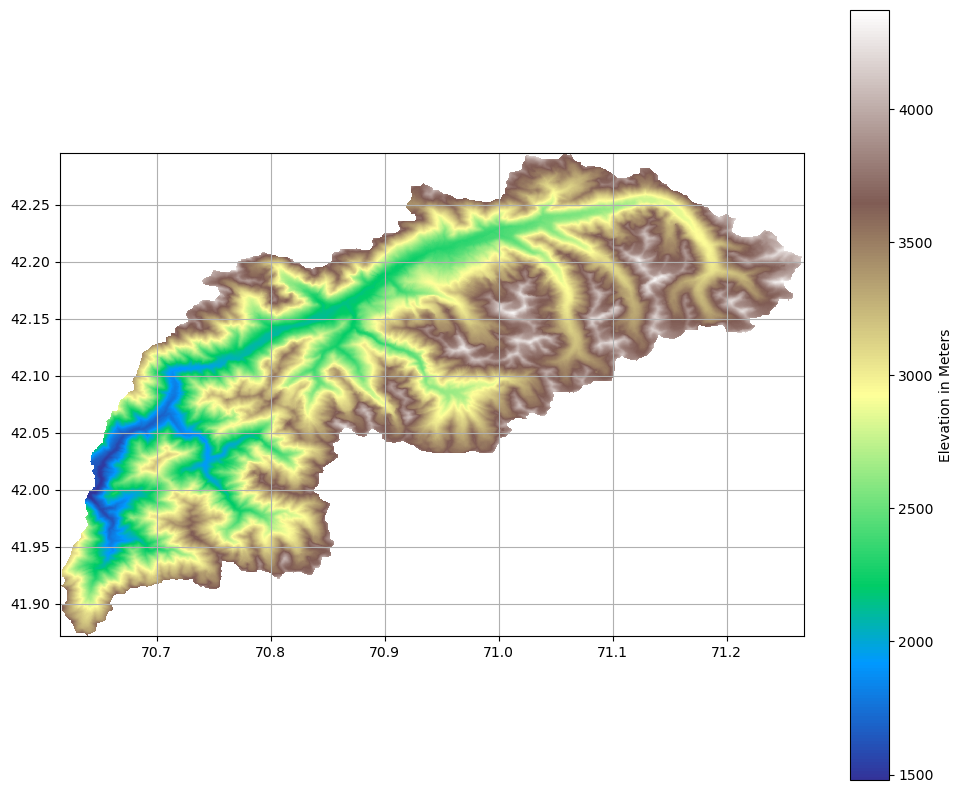

In [23]:
demView = grid.view(dem, nodata=np.nan)
plotFigure(demView,'Elevation in Meters',cmap='terrain')
plt.show()

We also need the catchment area as polygon to support spatial operations. Therefore convert the catchment raster to a polygon and save the result as geopackage to the output folder. Furthermore, some catchment statistics will be printed at the end of the cell. 

In [24]:
from shapely.geometry import Polygon
import pyproj
from shapely.geometry import shape
from shapely.ops import transform

# Create shapefile and save it
shapes = grid.polygonize()

schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

catchment_shape = {}
layer_name = 'catchment_orig'
with fiona.open(output_gpkg, 'w',
                #driver='ESRI Shapefile',#
                driver='GPKG',
                layer=layer_name,
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        catchment_shape = shape
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1 

print(f"Layer '{layer_name}' added to GeoPackage '{output_gpkg}'\n")
        
catchment_bounds = [int(np.nanmin(demView)),int(np.nanmax(demView))]
ele_cat = float(np.nanmean(demView))
print(f"Catchment elevation is between {catchment_bounds[0]} m and {catchment_bounds[1]} m")
print(f"Mean catchment elevation is {ele_cat:.2f} m")

Layer 'catchment_orig' added to GeoPackage 'output/catchment_data.gpkg'

Catchment elevation is between 1480 m and 4374 m
Mean catchment elevation is 3111.92 m


Add the polygon of the catchment area to the interactive map and calculate its area with GEE. Please scroll up to see the results on the map.

In [25]:
catchment = ee.Geometry.Polygon(catchment_shape['coordinates'])
if show_map:
    Map.addLayer(catchment, {}, 'Catchment')

catchment_area = catchment.area().divide(1000*1000).getInfo()
print(f"Catchment area is {catchment_area:.2f} km²")

Catchment area is 1107.65 km²


**<font color="red">Attention!</font>** Please check that there is some buffer between the catchment area and the used box. If the catchment area is close to the box outline, please extent the box and repeat the DEM download and catchment delineation (&rarr; use [Restart Point #1](#rp01)).

Example:

1. automatically created box for pouring point (in grey) is not sufficient to capture the entire catchment &rarr; cropped at the Eastern end
2. manually drawn box (in blue) has been added to make sure that the catchment is not cropped &rarr; space remains on all edges

![Example for Cropped Catchment](images/gee_catchment_extent.png)

___

## Determine glaciers in catchment area

The RGI 6.0 glacier outline inventory will be used to determine all glaciers that belong to the catchment area.

> The *Randolph Glacier Inventory (RGI 6.0)* is a global inventory of glacier outlines. It is supplemental to the Global Land Ice Measurements from Space initiative (GLIMS). Production of the RGI was motivated by the Fifth Assessment Report of the Intergovernmental Panel on Climate Change (IPCC AR5). Future updates will be made to the RGI and the GLIMS Glacier Database in parallel during a transition period. As all these data are incorporated into the GLIMS Glacier Database and as download tools are developed to obtain GLIMS data in the RGI data format, the RGI will evolve into a downloadable subset of GLIMS, offering complete one-time coverage, version control, and a standard set of attributes.
>
> Source: https://www.glims.org/RGI/

The RGI dataset is divided into 19 so called *first-order regions*. 

> RGI regions were developed under only three constraints: that theyshould resemble commonly recognized glacier domains,that together they should contain all of the world’s glaciers,and that their boundaries should be simple and readilyrecognizable on a map of the world. 
>
> Source (PDF): Pfeffer, W. Tad, Anthony A. Arendt, Andrew Bliss, Tobias Bolch, J. Graham Cogley, Alex S. Gardner, Jon-Ove Hagen, et al. 2014. “The Randolph Glacier Inventory: A Globally Complete Inventory of Glaciers.” Journal of Glaciology. International Glaciological Society. https://doi.org/10.3189/2014jog13j176.

![Map of the RGI regions; the red dots indicate the glacier locations and the blue circles the location of the 254 reference WGMS glaciers used by the OGGM calibration](https://docs.oggm.org/en/v1.2.0/_images/wgms_rgi_map.png)

In the first step, the RGI region of the catchment area must be determined to collect the right glacier outlines in a later step. Therefore, the RGI region outlines will be downloaded from the official website and spatially joined with the catchment area outline.

> Source: RGI Consortium, 2017. Randolph Glacier Inventory - A Dataset of Global Glacier Outlines, Version 6. [RGI Regions, RGI Glacier Outlines]. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi: https://doi.org/10.7265/4m1f-gd79

In [30]:
import geopandas as gpd

# load catcment and RGI regions as DF
catchment = gpd.read_file(output_gpkg, layer='catchment_orig')
df_regions = gpd.read_file('https://www.glims.org/RGI/rgi60_files/00_rgi60_regions.zip')
display(df_regions)

,FULL_NAME,RGI_CODE,WGMS_CODE,geometry
0,Alaska,1,ALA,"POLYGON ((-133.00000 54.50000, -134.00000 54.5..."
1,Alaska,1,ALA,"POLYGON ((180.00000 50.00000, 179.00000 50.000..."
2,Western Canada and USA,2,WNA,"POLYGON ((-133.00000 54.50000, -132.00000 54.5..."
3,"Arctic Canada, North",3,ACN,"POLYGON ((-125.00000 74.00000, -125.00000 75.0..."
4,"Arctic Canada, South",4,ACS,"POLYGON ((-90.00000 74.00000, -89.00000 74.000..."
5,Greenland Periphery,5,GRL,"POLYGON ((-75.00000 77.00000, -74.73000 77.510..."
6,Iceland,6,ISL,"POLYGON ((-26.00000 59.00000, -26.00000 60.000..."
7,Svalbard and Jan Mayen,7,SJM,"POLYGON ((-10.00000 70.00000, -10.00000 71.000..."
8,Scandinavia,8,SCA,"POLYGON ((4.00000 70.00000, 4.00000 71.00000, ..."
9,Russian Arctic,9,RUA,"POLYGON ((35.00000 70.00000, 35.00000 71.00000..."


For spatial operations and calculations it is crucial to use the correct projection. Otherwise, they could produce unexpected outputs. The relevant UTM zone and band for the catchment area can be automatically determined from the coordinates of the pouring point.

In [31]:
import utm
from pyproj import CRS

utm_zone = utm.from_latlon(y, x)
print(f"UTM zone '{utm_zone[2]}', band '{utm_zone[3]}'")

# get CRS based on UTM
crs = CRS.from_dict({'proj':'utm', 'zone':utm_zone[2], 'south':False})

catchment_area = catchment.to_crs(crs).area[0] / 1000 / 1000
print(f"Catchment area (projected) is {catchment_area:.2f} km²")

UTM zone '42', band 'T'
Catchment area (projected) is 1109.16 km²


Now do spatial join between catchment area and RGI regions by using the determined projection. If the catchment area contains any glaciers, the corresponding RGI region should be determined in this step. 

In [32]:
df_regions = df_regions.set_crs('EPSG:4326', allow_override=True)
catchment = catchment.to_crs('EPSG:4326')
df_regions_catchment = gpd.sjoin(df_regions, catchment, how="inner", predicate="intersects")

if len(df_regions_catchment.index) == 0:
    print('No area found for catchment')
    rgi_region = None
elif len(df_regions_catchment.index) == 1:
    rgi_region = df_regions_catchment.iloc[0]['RGI_CODE']
    print(f"Catchment belongs to RGI region {rgi_region} ({df_regions_catchment.iloc[0]['FULL_NAME']})")
else:
    print("Catchment belongs to more than one region. This use case is not yet supported.")
    display(df_regions_catchment)
    rgi_region = None

Catchment belongs to RGI region 13 (Asia, Central)


In the next step, the glacier inventory outlines for the determined RGI region will be downloaded. A spatial join is performed to determine all glacier outlines that intersect with the catchment area.

**Note**: Depending on the region and bandwidth, this might take some time. 

In [33]:
%%time

import urllib.request
import re

if rgi_region != None:
    url = "https://www.glims.org/RGI/rgi60_files/"  # Replace with the URL of your web server
    html_page = urllib.request.urlopen(url)
    html_content = html_page.read().decode("utf-8")
    print('Reading Randolph Glacier Inventory 6.0 in GLIMS database...')

    # Use regular expressions to find links to files
    pattern = re.compile(r'href="([^"]+\.zip)"')
    file_links = pattern.findall(html_content)


    for file in file_links:
        splits = file.split("_")
        if splits[0] != str(rgi_region):
            continue

        # starting scanning regions
        regionname = splits[0] + " (" + splits[2].split(".")[0] + ")"
        print(f'Locating glacier outlines in RGI Region {regionname}...')

        # read zip into dataframe
        print('Loading shapefiles...')
        rgi = gpd.read_file(url+file)
        if rgi.crs != catchment.crs:
            print("CRS adjusted")
            catchment = catchment.to_crs(rgi.crs)

        # check whether catchment intersects with glaciers of region
        print('Do spatial join...')
        rgi_catchment = gpd.sjoin(rgi,catchment,how='inner',predicate='intersects')
        if len(rgi_catchment.index) > 0:
            print(f'{len(rgi_catchment.index)} outlines loaded from RGI Region {regionname}\n')

Reading Randolph Glacier Inventory 6.0 in GLIMS database...
Locating glacier outlines in RGI Region 13 (CentralAsia)...
Loading shapefiles...
Do spatial join...
138 outlines loaded from RGI Region 13 (CentralAsia)

CPU times: total: 6.41 s
Wall time: 25.9 s


Some glaciers do not belong to catchment but are intersecting the derived catchment area. Therefore, the percentage of the glacier will be calculated. The percentage value for each glacier will be printed.

In [39]:
# intersects selects too many. calculate percentage of glacier area that is within catchment
rgi_catchment['rgi_area'] = rgi_catchment.to_crs(crs).area    
    
gdf_joined = gpd.overlay(catchment, rgi_catchment, how='union')
gdf_joined['area_joined'] = gdf_joined.to_crs(crs).area
gdf_joined['share_of_area'] = (gdf_joined['area_joined'] / gdf_joined['rgi_area'] * 100)

results = (gdf_joined
           .groupby(['RGIId', 'LABEL_1'])
           .agg({'share_of_area': 'sum'}))

display(results.sort_values(['share_of_area'],ascending=False))

,,share_of_area
RGIId,LABEL_1,
RGI60-13.22155,1.0,100.000000
RGI60-13.21866,1.0,100.000000
RGI60-13.21831,1.0,100.000000
RGI60-13.21867,1.0,100.000000
RGI60-13.21865,1.0,100.000000
...,...,...
RGI60-13.21910,1.0,0.075846
RGI60-13.21844,1.0,0.051481
RGI60-13.22126,1.0,0.033615


The next step, we need to filter on the glaciers and decide whether they belong to the catchment or not. This is done based on the percentage area of the shared area. After the filtering, the catchment area will be adjusted as follows:

- include glaciers where &#8805;50% of the area is part of the catchment &rarr; extend catchment area by glacier outlines (if needed)
- exclude glaciers where <50% of the area is part of the catchment &rarr; reduce catchment area by glaicer outlines (if needed)

In [40]:
import pandas as pd
rgi_catchment_merge = pd.merge(rgi_catchment, results, on="RGIId")
rgi_in_catchment = rgi_catchment_merge.loc[rgi_catchment_merge['share_of_area'] >= 50]
rgi_out_catchment = rgi_catchment_merge.loc[rgi_catchment_merge['share_of_area'] < 50]
catchment_new = gpd.overlay(catchment, rgi_out_catchment, how='difference')
catchment_new = gpd.overlay(catchment_new, rgi_in_catchment, how='union')
catchment_new = catchment_new.dissolve()[['LABEL_1', 'geometry']]

print(f'Total number of determined glacier outlines: {len(rgi_catchment_merge)}')
print(f'Number of included glacier outlines (overlap >= 50%): {len(rgi_in_catchment)}')
print(f'Number of excluded glacier outlines (overlap < 50%): {len(rgi_out_catchment)}')

Total number of determined glacier outlines: 138
Number of included glacier outlines (overlap >= 50%): 110
Number of excluded glacier outlines (overlap < 50%): 28


Now write RGI-IDs of glaciers that belong to the catchment to CSV file `Glaciers_in_catchment.csv`.

In [41]:
from pathlib import Path
Path(output_folder + 'RGI').mkdir(parents=True, exist_ok=True)

glacier_ids = pd.DataFrame(rgi_in_catchment)
glacier_ids['RGIId'] = glacier_ids['RGIId'].map(lambda x: str(x).lstrip('RGI60-'))
glacier_ids.to_csv(output_folder + 'RGI/' + 'Glaciers_in_catchment.csv', columns=['RGIId', 'GLIMSId'], index=False)
display(glacier_ids.head())

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Form,TermType,Surging,Linkages,Name,geometry,index_right,LABEL,rgi_area,share_of_area
0,13.21776,G071251E42189N,20000923,-9999999,71.250704,42.188778,13,3,1.180,3796,...,0,0,9,9,NaN,"POLYGON ((71.23846 42.18576, 71.23843 42.18583...",0,1.0,1.179581e+06,99.999682
1,13.21777,G071203E42172N,20000923,-9999999,71.202994,42.171707,13,3,0.322,3603,...,0,0,9,9,NaN,"POLYGON ((71.19752 42.17080, 71.19759 42.17080...",0,1.0,3.223635e+05,100.000000
7,13.21791,G071208E42144N,20000923,-9999999,71.208121,42.143779,13,3,1.446,3550,...,0,0,9,9,NaN,"POLYGON ((71.22165 42.14367, 71.22212 42.14366...",0,1.0,1.446355e+06,100.000000
8,13.21792,G071153E42142N,20000923,-9999999,71.152707,42.141893,13,3,2.724,3492,...,0,0,9,9,NaN,"POLYGON ((71.13985 42.14291, 71.14032 42.14324...",0,1.0,2.723815e+06,100.000000
9,13.21793,G071109E42124N,20000923,-9999999,71.109431,42.123954,13,3,0.109,3728,...,0,0,9,9,NaN,"POLYGON ((71.10569 42.12519, 71.10606 42.12546...",0,1.0,1.084953e+05,100.000000


Now let's do spatial calculations and determine the final size of catchment area and glacierized area within catchment.

In [42]:
catchment_new['area'] = catchment_new.to_crs(crs)['geometry'].area
area_glac = rgi_in_catchment.to_crs(crs)['geometry'].area

area_glac = area_glac.sum()/1000000
area_cat = catchment_new.iloc[0]['area']/1000000
cat_cent = catchment_new.to_crs(crs).centroid
lat = cat_cent.to_crs('EPSG:4326').y[0]

print(f"New catchment area is {area_cat:.2f} km²")
print(f"Glacierized catchment area is {area_glac:.2f} km²")

New catchment area is 1109.17 km²
Glacierized catchment area is 45.69 km²


Export geo data to the existing geopackage:
<ul>
    <li>RGI glaciers within catchment</li>
    <li>RGI glaciers outside catchment</li>
    <li>Adjusted catchment area based in RGI glacier outlines</li>
</ul>

In [43]:
rgi_in_catchment.to_file(output_gpkg, layer='rgi_in', driver='GPKG')
print(f"Layer 'rgi_in' added to GeoPackage '{output_gpkg}'")

rgi_out_catchment.to_file(output_gpkg, layer='rgi_out', driver='GPKG')
print(f"Layer 'rgi_out' added to GeoPackage '{output_gpkg}'")

catchment_new.to_file(output_gpkg, layer='catchment_new', driver='GPKG')
print(f"Layer 'catchment_new' added to GeoPackage '{output_gpkg}'")

Layer 'rgi_in' added to GeoPackage 'output/catchment_data.gpkg'
Layer 'rgi_out' added to GeoPackage 'output/catchment_data.gpkg'
Layer 'catchment_new' added to GeoPackage 'output/catchment_data.gpkg'


The determined glacier outlines (within catchment) as well as the new catchment area can now be added to the interactive map.

In [44]:
c_new = geemap.geopandas_to_ee(catchment_new)
rgi = geemap.geopandas_to_ee(rgi_in_catchment)

if show_map:
    Map.addLayer(c_new, {'color': 'orange'}, "Catchment New")
    Map.addLayer(rgi, {'color': 'white'}, "RGI60")

&rarr; [Jump to map](#map) to see results.

After adding the new catchment area to GEE, we can easily calculate the mean catchment elevation in meters above sea level.

In [45]:
ele_cat = image.reduceRegion(ee.Reducer.mean(),
                          geometry=c_new).getInfo()[dem_config[2]] 
print(f"Mean catchment elevation (adjusted) is {ele_cat:.2f} m.a.s.l.")

Mean catchment elevation (adjusted) is 3111.86 m.a.s.l.


**Interim result**: we have determined the catchment area and we know which glaciers belong to the catchment. The next step, we need to create a glacier profile, i.e. how much ice is stored at what altitude.

___

## Retrieve raster files for ice thickness and corresponding DEM raster files

> Knowledge of the ice thickness distribution of the world’s glaciers is a fundamental prerequisite for a range of studies. Projections of future glacier change, estimates of the available freshwater resources or assessments of potential sea-level rise all need glacier ice thickness to be accurately constrained.
>
> Source: Farinotti, D., Huss, M., Fürst, J.J. et al. A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nat. Geosci. 12, 168–173 (2019). https://doi.org/10.1038/s41561-019-0300-3

The authors of the article also published a repository providing

> (a) the ice thickness distribution of individual glaciers,<br/>
> (b) global grids at various resolutions with summary-information about glacier number, area, and volume, and<br/> 
> (c) the digital elevation models of the glacier surfaces used to produce the estimates.
> 
> Nomenclature for glaciers and regions follows the Randolph Glacier Inventory (RGI) version 6.0.
>
> Source: https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/315707/README.txt

The ice thickness (a) and the DEM of the glacier surface (c) are input data for out glacier profile. Both information have to be  determined from raster files. The raster files will be downloaded from the server for each glacier (using RGI-ID) and stored in the output folder. The thinkness raster files will be supported by DEM raster files for easier processing.

Since the original file archives are very big, the dataset is cut into smaller slices to increase performance and reuploaded to a media server. The original files are published by ETH Zürich and can be found here: https://www.research-collection.ethz.ch/handle/20.500.11850/315707

In a first step, the relevant archives for DEM/thickness need to be determined.

In [47]:
def getArchiveNames(row):
    region = row['RGIId'].split('.')[0]
    id = (int(row['RGIId'].split('.')[1]) - 1) // 1000 + 1
    return f'ice_thickness_RGI60-{region}_{id}', f'dem_surface_DEM_RGI60-{region}_{id}'


# determine relevant .zip files for derived RGI IDs 
df_rgiids = pd.DataFrame(rgi_in_catchment['RGIId'].sort_values())
df_rgiids[['thickness', 'dem']] = df_rgiids.apply(getArchiveNames, axis=1, result_type='expand')
zips_thickness = df_rgiids['thickness'].drop_duplicates()
zips_dem = df_rgiids['dem'].drop_duplicates()

print(f'Thickness archives:\t{zips_thickness.tolist()}')
print(f'DEM archives:\t\t{zips_dem.tolist()}')

Thickness archives:	['ice_thickness_RGI60-13_22', 'ice_thickness_RGI60-13_23']
DEM archives:		['dem_surface_DEM_RGI60-13_22', 'dem_surface_DEM_RGI60-13_23']


The archives are stored on a media server with specific references. Find the right resource references for the previously determined archives in the next step. 

In [49]:
from resourcespace import ResourceSpace

# use guest credentials to access media server
api_base_url = 'https://rs.cms.hu-berlin.de/matilda/api/?'  
private_key = '9a19c0cee1cde5fe9180c31c27a8145bc6f7a110cfaa3806ba262eb63d16f086' 
user = 'gast' 

myrepository = ResourceSpace(api_base_url, user, private_key)

# get resource IDs for each .zip file
refs_thickness = pd.DataFrame(myrepository.get_collection_resources(12))[['ref', 'file_size', 'file_extension', 'field8']]
refs_dem = pd.DataFrame(myrepository.get_collection_resources(21))[['ref', 'file_size', 'file_extension', 'field8']]

# reduce list of resources two required zip files 
refs_thickness = pd.merge(zips_thickness, refs_thickness, left_on='thickness', right_on='field8')
refs_dem = pd.merge(zips_dem, refs_dem, left_on='dem', right_on='field8')

print(f'Thickness archive references:')
display(refs_thickness)
print(f'DEM archive references:')
display(refs_dem)

Thickness archive references:


,thickness,ref,file_size,file_extension,field8
0,ice_thickness_RGI60-13_22,26979,3571604,zip,ice_thickness_RGI60-13_22
1,ice_thickness_RGI60-13_23,26984,4394149,zip,ice_thickness_RGI60-13_23


DEM archive references:


,dem,ref,file_size,file_extension,field8
0,dem_surface_DEM_RGI60-13_22,27165,6716056,zip,dem_surface_DEM_RGI60-13_22
1,dem_surface_DEM_RGI60-13_23,27176,9682723,zip,dem_surface_DEM_RGI60-13_23


**Ice thickness**: download relevant archives from server and extract `.tif` files to output folder.

> Contains the ice thickness distribution of all glaciers of the RGI as estimated by the ensemble of considered models. Ice thicknesses are given in meters.

In [50]:
%%time

import requests
from zipfile import ZipFile
import io

cnt_thickness = 0
file_names_thickness = []
for idx, row in refs_thickness.iterrows():
    content = myrepository.get_resource_file(row['ref'])    
    with ZipFile(io.BytesIO(content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for rgiid in df_rgiids.loc[df_rgiids['thickness'] == row['field8']]['RGIId']:
            filename = 'RGI60-' + rgiid + '_thickness.tif'
            if filename in listOfFileNames:
                cnt_thickness += 1
                zipObj.extract(filename, output_folder+'RGI')
                file_names_thickness.append(filename)
            else:
                print(f'File not found: {filename}')
                
print(f'{cnt_thickness} files have been extracted (ice thickness)')

110 files have been extracted (ice thickness)
CPU times: total: 594 ms
Wall time: 4.13 s


**DEM**: download relevant archives from server and extract `.tif` files to output folder.

> Contains the digital elevation models (DEMs) of the glacier surfaces, as used during the calculations. The DEMs have the same extent and resolution as the corresponding ice thickness data, thus allowing for a subglacial topography to be computed (subtract the thickness from the surface DEM). Surface elevations are given in meters above sea level. 

In [51]:
%%time

cnt_dem = 0
file_names_dem = []
for idx,row in refs_dem.iterrows():   
    content = myrepository.get_resource_file(row['ref'])    
    with ZipFile(io.BytesIO(content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for rgiid in df_rgiids.loc[df_rgiids['dem']==row['field8']]['RGIId']:
            filename = f"surface_DEM_RGI60-{rgiid}.tif"
            if filename in listOfFileNames:
                cnt_dem += 1
                zipObj.extract(filename, output_folder+'RGI')
                file_names_dem.append(filename)
            else:
                print(f'File not found: {filename}')
                
print(f'{cnt_dem} files have been extracted (DEM)')

110 files have been extracted (DEM)
CPU times: total: 641 ms
Wall time: 4.47 s


**<font color="red">Attention!</font>** Check that all files have been extracted to the output folder (i.e. no error message printed) and that the number of files matches the number of glaciers within the catchment area.

In [61]:
if len(rgi_in_catchment) == cnt_thickness == cnt_dem:
    print(f"Number of files matches the number of glaciers within catchment: {len(rgi_in_catchment)}")
else:
    print("There is a mismatch of extracted files. Please check previous steps for error messages!")
    print(f'Number of included glaciers:\t{len(rgi_in_catchment)}')
    print(f'Ice thickness files:\t\t{cnt_thickness}')
    print(f'DEM files:\t\t\t{cnt_dem}')

Number of files matches the number of glaciers within catchment: 110


## Glacier profile creation

Overlay ice thickness and DEM raster for each glacier to create tuples. By this, we now know the ice thickness of a given glacier at a particular altitude.

In [64]:
from osgeo import gdal

df_all = pd.DataFrame()
if cnt_thickness != cnt_dem:
    print('Number of ice thickness raster files does not match number of DEM raster files!')
else:
    for idx, rgiid in enumerate(df_rgiids['RGIId']):
        if rgiid in file_names_thickness[idx] and rgiid in file_names_dem[idx]:
            file_list = [
                output_folder + 'RGI/' + file_names_thickness[idx],
                output_folder + 'RGI/' + file_names_dem[idx]
            ]
            array_list = []

            # Read arrays
            for file in file_list:
                src = gdal.Open(file)
                geotransform = src.GetGeoTransform() # Could be done more elegantly outside the for loop
                projection = src.GetProjectionRef()
                array_list.append(src.ReadAsArray())
                pixelSizeX = geotransform[1]
                pixelSizeY =-geotransform[5]                
                src = None
            
            df = pd.DataFrame()
            df['thickness'] = array_list[0].flatten()
            df['altitude'] = array_list[1].flatten()
            df_all = pd.concat([df_all, df])
        else:
            print(f'Raster files do not match for {rgiid}')

Now, remove all data points with zero ice thickness (note relevant for glaicer profile) and aggregate all data points to 10m elevation zones. In the next step, the **water equivalent** (WE) can be calculated from the average ice thickness of a data point.

The result is exported to the output folder as CSV file `glacier_profile.csv`.

In [65]:
if len(df_all) > 0:
    df_all = df_all.loc[df_all['thickness'] > 0]
    df_all.sort_values(by=['altitude'],inplace=True)
    
    # get min/max altitude considering catchment and all glaciers
    alt_min = 10*int(min(catchment_bounds[0],df_all['altitude'].min())/10)
    alt_max = max(catchment_bounds[1],df_all['altitude'].max())+10
        
    # create bins in 10m steps
    bins = np.arange(alt_min, df_all['altitude'].max()+10, 10)
    
    # aggregate per bin and do some math
    df_agg = df_all.groupby(pd.cut(df_all['altitude'], bins))['thickness'].agg(count='size', mean='mean').reset_index()
    df_agg['Elevation'] = df_agg['altitude'].apply(lambda x: x.left)
    df_agg['Area'] = df_agg['count']*pixelSizeX*pixelSizeY / catchment_new.iloc[0]['area']
    df_agg['WE'] = df_agg['mean']*0.908*1000
    df_agg['EleZone'] = df_agg['Elevation'].apply(lambda x: 100*int(x/100))
    
    # delete empty elevation bands but keep at least one entry per elevation zone
    df_agg=pd.concat([df_agg.loc[df_agg['count']>0],
                      df_agg.loc[df_agg['count']==0].drop_duplicates(['EleZone'],keep='first')]
                    ).sort_index()
    
    df_agg.drop(['altitude', 'count', 'mean'], axis=1, inplace=True)
    df_agg = df_agg.replace(np.nan, 0)
    df_agg.to_csv(output_folder + 'glacier_profile.csv', header=True, index=False)
    print('Glacier profile for catchment successfully created!')
    display(df_agg)

Glacier profile for catchment successfully created!


,Elevation,Area,WE,EleZone
0,1480.0,0.000000e+00,0.000000,1400
2,1500.0,0.000000e+00,0.000000,1500
12,1600.0,0.000000e+00,0.000000,1600
22,1700.0,0.000000e+00,0.000000,1700
32,1800.0,0.000000e+00,0.000000,1800
...,...,...,...,...
284,4320.0,2.817430e-06,15952.318359,4300
285,4330.0,3.380917e-06,14490.752930,4300
286,4340.0,2.253944e-06,13173.493164,4300
287,4350.0,1.690458e-06,13949.658203,4300


Calculate average glacier elevation in meters above sea level.

In [70]:
ele_glac = round(df_all.altitude.mean(), 2)
print(f'Average glacier elevation in the catchment: {ele_glac:.2f} m.a.s.l.')

Average glacier elevation in the catchment: 3752.36 m.a.s.l.


# Store calculated values for other notebooks

Create a `settings.yaml` and store the relevant catchment information. Those information will be used in later notebooks:

- **area_cat**: area of catchment in km²
- **ele_cat**: average elevation of catchment in m.a.s.l.
- **area_glac**: area of glacier in km²
- **ele_glac**: average elevation of glaciers in m.a.s.l.
- **lat**: latitude of catchment centroid

In [74]:
import yaml

settings = {'area_cat': float(area_cat),
            'ele_cat': float(ele_cat),
            'area_glac': float(area_glac),
            'ele_glac': float(ele_glac),
            'lat': float(lat)
           }
with open(output_folder + 'settings.yml', 'w') as f:
    yaml.safe_dump(settings, f)

print('Settings saved to file.')
display(pd.DataFrame(settings.items(),columns=['Parameter','Value']).set_index('Parameter'))

NameError: name 'area_cat' is not defined

In [73]:
%reset -f